In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from editdistance import eval as edit_distance

from simplipy import SimpliPyEngine

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.metrics import bootstrapped_metric_ci
from flash_ansr.eval.token_prediction import f1_score, precision, recall

In [20]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [21]:
engine = SimpliPyEngine.load('dev_7-3', install=True)

In [22]:
# with open(os.path.join(PATH_TO_EVALUATION_DATA, 'v22.0-60M', 'evaluation_256', 'pool_15_10.pickle'), 'rb') as f:
#     result = pickle.load(f)

In [23]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    # 'PySR': {'scaling_parameter': 'niterations'},
    'v22.0-60M': {'scaling_parameter': 'choices'},
    'v22.1-60M': {'scaling_parameter': 'choices'},
}

In [24]:
models_not_found = []
for model in results.keys():
    print(f"Processing model {model}")
    if not 'scaling_parameter' in results[model]:
        raise ValueError("Please specify the scaling parameter for the model.")
    scaling_parameter = results[model]['scaling_parameter']

    # In the directory, there are multiple directories named "evaluation_<scaling_parameter_name>_<scaling_parameter_value>.yaml",
    # each each containing files "<test_set_name>.pickle" with the evaluation results for a specific test set.
    try:
        evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, f'{model}'))
    except FileNotFoundError:
        models_not_found.append(model)
        print(f" - No evaluations found for model {model}, skipping.")
        continue

    evaluations_list = [d for d in evaluations_list if d.startswith(f'evaluation_')]
    scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

    scaling_values_argsort = np.argsort(scaling_values)
    scaling_values = [scaling_values[i] for i in scaling_values_argsort]
    evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

    results[model]['scaling_values'] = scaling_values
    results[model]['evaluations_list'] = evaluations_list
    results[model]['results'] = {}

    print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
    for d in evaluations_list:
        print(f" - {d}")

for model_not_found in models_not_found:
    del results[model_not_found]

Processing model v22.0-60M
Found 1 evaluations with scaling values: [256]
 - evaluation_256
Processing model v22.1-60M
Found 1 evaluations with scaling values: [256]
 - evaluation_256


In [25]:
TEST_SETS_FILTER = ['pool_15_10', 'feynman']

In [26]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for d in tqdm(results[model]['evaluations_list'], desc="Loading evaluation results"):
        for test_set in TEST_SETS_FILTER:
            path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, f'{model}', d, f"{test_set}.pickle")
            if not os.path.exists(path_to_pickle):
                print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                continue
            with open(path_to_pickle, 'rb') as f:
                try:
                    result = pickle.load(f)
                except Exception as e:
                    print(f"Error loading {path_to_pickle}: {e}")
                    continue
            niterations = int(d.split('_')[-1].split('.')[0])
            if test_set not in results[model]['results']:
                results[model]['results'][test_set] = {}
            results[model]['results'][test_set][niterations] = result

    print(results[model]['results'].keys())

Loading evaluation results: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


dict_keys(['pool_15_10'])


Loading evaluation results: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

dict_keys(['pool_15_10'])


In [27]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'skeleton': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_expression': [],
    'predicted_expression_prefix': [],
    'predicted_skeleton_prefix': [],
    'predicted_constants': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,

    'f1_score': 0.0,
    'expression_length': np.inf,
    'predicted_skeleton_prefix_length': np.inf,
    'fvu_fit': np.inf,
    'fvu_val': np.inf,
    'log10_fvu_fit': np.inf,
    'log10_fvu_val': np.inf,
    'only_approx_fvu_fit': np.inf,
    'only_approx_fvu_val': np.inf,
    'only_approx_log10_fvu_fit': np.inf,
    'only_approx_log10_fvu_val': np.inf,
    'numeric_recovery_fit': 0.0,
    'numeric_recovery_val': 0.0,
    'n_variables': np.nan,
    'n_constants': np.inf,
    'predicted_n_constants': np.inf,
    'n_constants_delta': np.inf,
    'symbolic_recovery': 0.0,
    'skeleton_length_ratio': np.inf,
    'edit_distance': np.inf,
    'unique_variables': np.nan,
    'predicted_unique_variables': 0,
    'f1_score_unique_variables': 0.0,
    'precision_unique_variables': 0.0,
    'recall_unique_variables': 0.0,
    'total_nestedness': np.nan,
    'predicted_total_nestedness': np.inf,
}

In [28]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array([(DEFAULT_NEGATIVES[metric] if r is None else r) for r in results[model]['results'][test_set][niterations][metric]])
                except ValueError:
                    pass  # setting an array element with a sequence

In [29]:
results.keys()

dict_keys(['v22.0-60M', 'v22.1-60M'])

In [30]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return np.inf
        return 0
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
    y_pred = y_pred.astype(np.float64)
    y_true = y_true.astype(np.float64)

    # Check if the ground truth is finite but the prediction is not
    if np.isfinite(y_true).all() and not np.isfinite(y_pred).all():
        return np.inf

    # Scale y_true and y_pred by the inverse of the mean squared error to avoid numerical issues
    ss_res = np.mean((y_true - y_pred) ** 2)
    if ss_res == 0:
        return 0
    scale = 1 / ss_res

    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)

    return safe_divide(ss_res, ss_tot)

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps

def total_nestedness(prefix_skeleton: list[str]) -> int:
    nestedness = 0
    current_depth = 0
    for i, token in enumerate(prefix_skeleton):
        if engine.operator_arity.get(token, 0) == 1:
            current_depth += 1
        else:
            nestedness += max(0, current_depth - 1)
            current_depth = 0

    return nestedness

for model in results.keys():
    for test_set in tqdm(results[model]['results'].keys()):
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                r = results[model]['results'][test_set][scaling_value]
                r[f'fvu_{split}'] = np.array([fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'log10_fvu_{split}'] = np.array([log10_fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'numeric_recovery_{split}'] = np.array([is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])

                r[f'only_approx_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'fvu_{split}'])
                r[f'only_approx_log10_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'log10_fvu_{split}'])

            r['f1_score'] = np.array([
                f1_score(np.array([predicted_skeleton_prefix]), np.array([skeleton])) if predicted_skeleton_prefix is not None else None  # Will be filled with default negatives in the cell below
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton'])])

            r['skeleton_length'] = np.array([
                len(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton']])
            
            r['predicted_skeleton_prefix_length'] = np.array([
                len(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton']])
            
            r['n_constants'] = np.array([
                skeleton.count('<constant>') if skeleton is not None else None
                for skeleton in r['skeleton']])
            
            r['predicted_n_constants'] = np.array([
                predicted_skeleton_prefix.count('<constant>') if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_constants_delta'] = np.array([
                predicted_n_constants - true_n_constants if predicted_n_constants is not None and true_n_constants is not None else None
                for predicted_n_constants, true_n_constants in zip(r['predicted_n_constants'], r['n_constants'])])

            r[f'symbolic_recovery'] = np.array([
                predicted_skeleton_prefix == skeleton if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton'])])

            r[f'skeleton_length_ratio'] = np.array([
                safe_divide(predicted_length, true_length) if predicted_length is not None and true_length is not None else None
                for predicted_length, true_length in zip(r['predicted_skeleton_prefix_length'], r['skeleton_length'])])

            r['edit_distance'] = np.array([
                edit_distance(predicted_skeleton_prefix, skeleton) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton'])])
            
            r['unique_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton']])

            r['predicted_unique_variables'] = np.array([
                len(set(token for token in predicted_skeleton_prefix if token.startswith('x'))) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['f1_score_unique_variables'] = np.array([
                f1_score(np.arange(predicted_unique_variables), np.arange(unique_variables)) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['precision_unique_variables'] = np.array([
                precision(np.arange(predicted_unique_variables), np.arange(unique_variables)) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['recall_unique_variables'] = np.array([
                recall(np.arange(predicted_unique_variables), np.arange(unique_variables)) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['total_nestedness'] = np.array([
                total_nestedness(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton']])

            r['predicted_total_nestedness'] = np.array([
                total_nestedness(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            

# print(results[list(results.keys())[0]]['results']['feynman'][1]['edit_distance'][:4])

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_17684/2702987276.py:23: RuntimeWarning: overflow encountered in square
  ss_res = np.mean((y_true - y_pred) ** 2)
100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


In [31]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array([(DEFAULT_NEGATIVES[metric] if r is None else r) for r in results[model]['results'][test_set][niterations][metric]])
                except ValueError:
                    pass  # setting an array element with a sequence

In [32]:
# results[list(results.keys())[0]]['results']['feynman'][1]['fvu_val'].shape, results[list(results.keys())[0]]['results']['feynman'][1]['fit_time'].shape

In [33]:
def arrow_notation(objective: int = 1, lower: float | str = 0, upper: float | str = 1, lower_open: bool = False, upper_open: bool = False):
    lower_bracket = '(' if lower_open else '['
    upper_bracket = ')' if upper_open else ']'

    if lower == -np.inf:
        lower_bracket = '('
        lower = '-\\infty'
    if upper == np.inf:
        upper_bracket = ')'
        upper = '\\infty'

    try:
        float(lower)
        lower = f"{lower:.2g}"
    except:
        pass

    try:
        float(upper)
        upper = f"{upper:.2g}"
    except:
        pass

    if objective == 1:
        return f"\\uparrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    elif objective == -1:
        return f"\\downarrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    else:
        raise ValueError("Objective must be 1 (higher is better) or -1 (lower is better).")

In [34]:
def naninfmean(a):
    a = np.array(a)
    return np.nanmean(a[np.isfinite(a)])

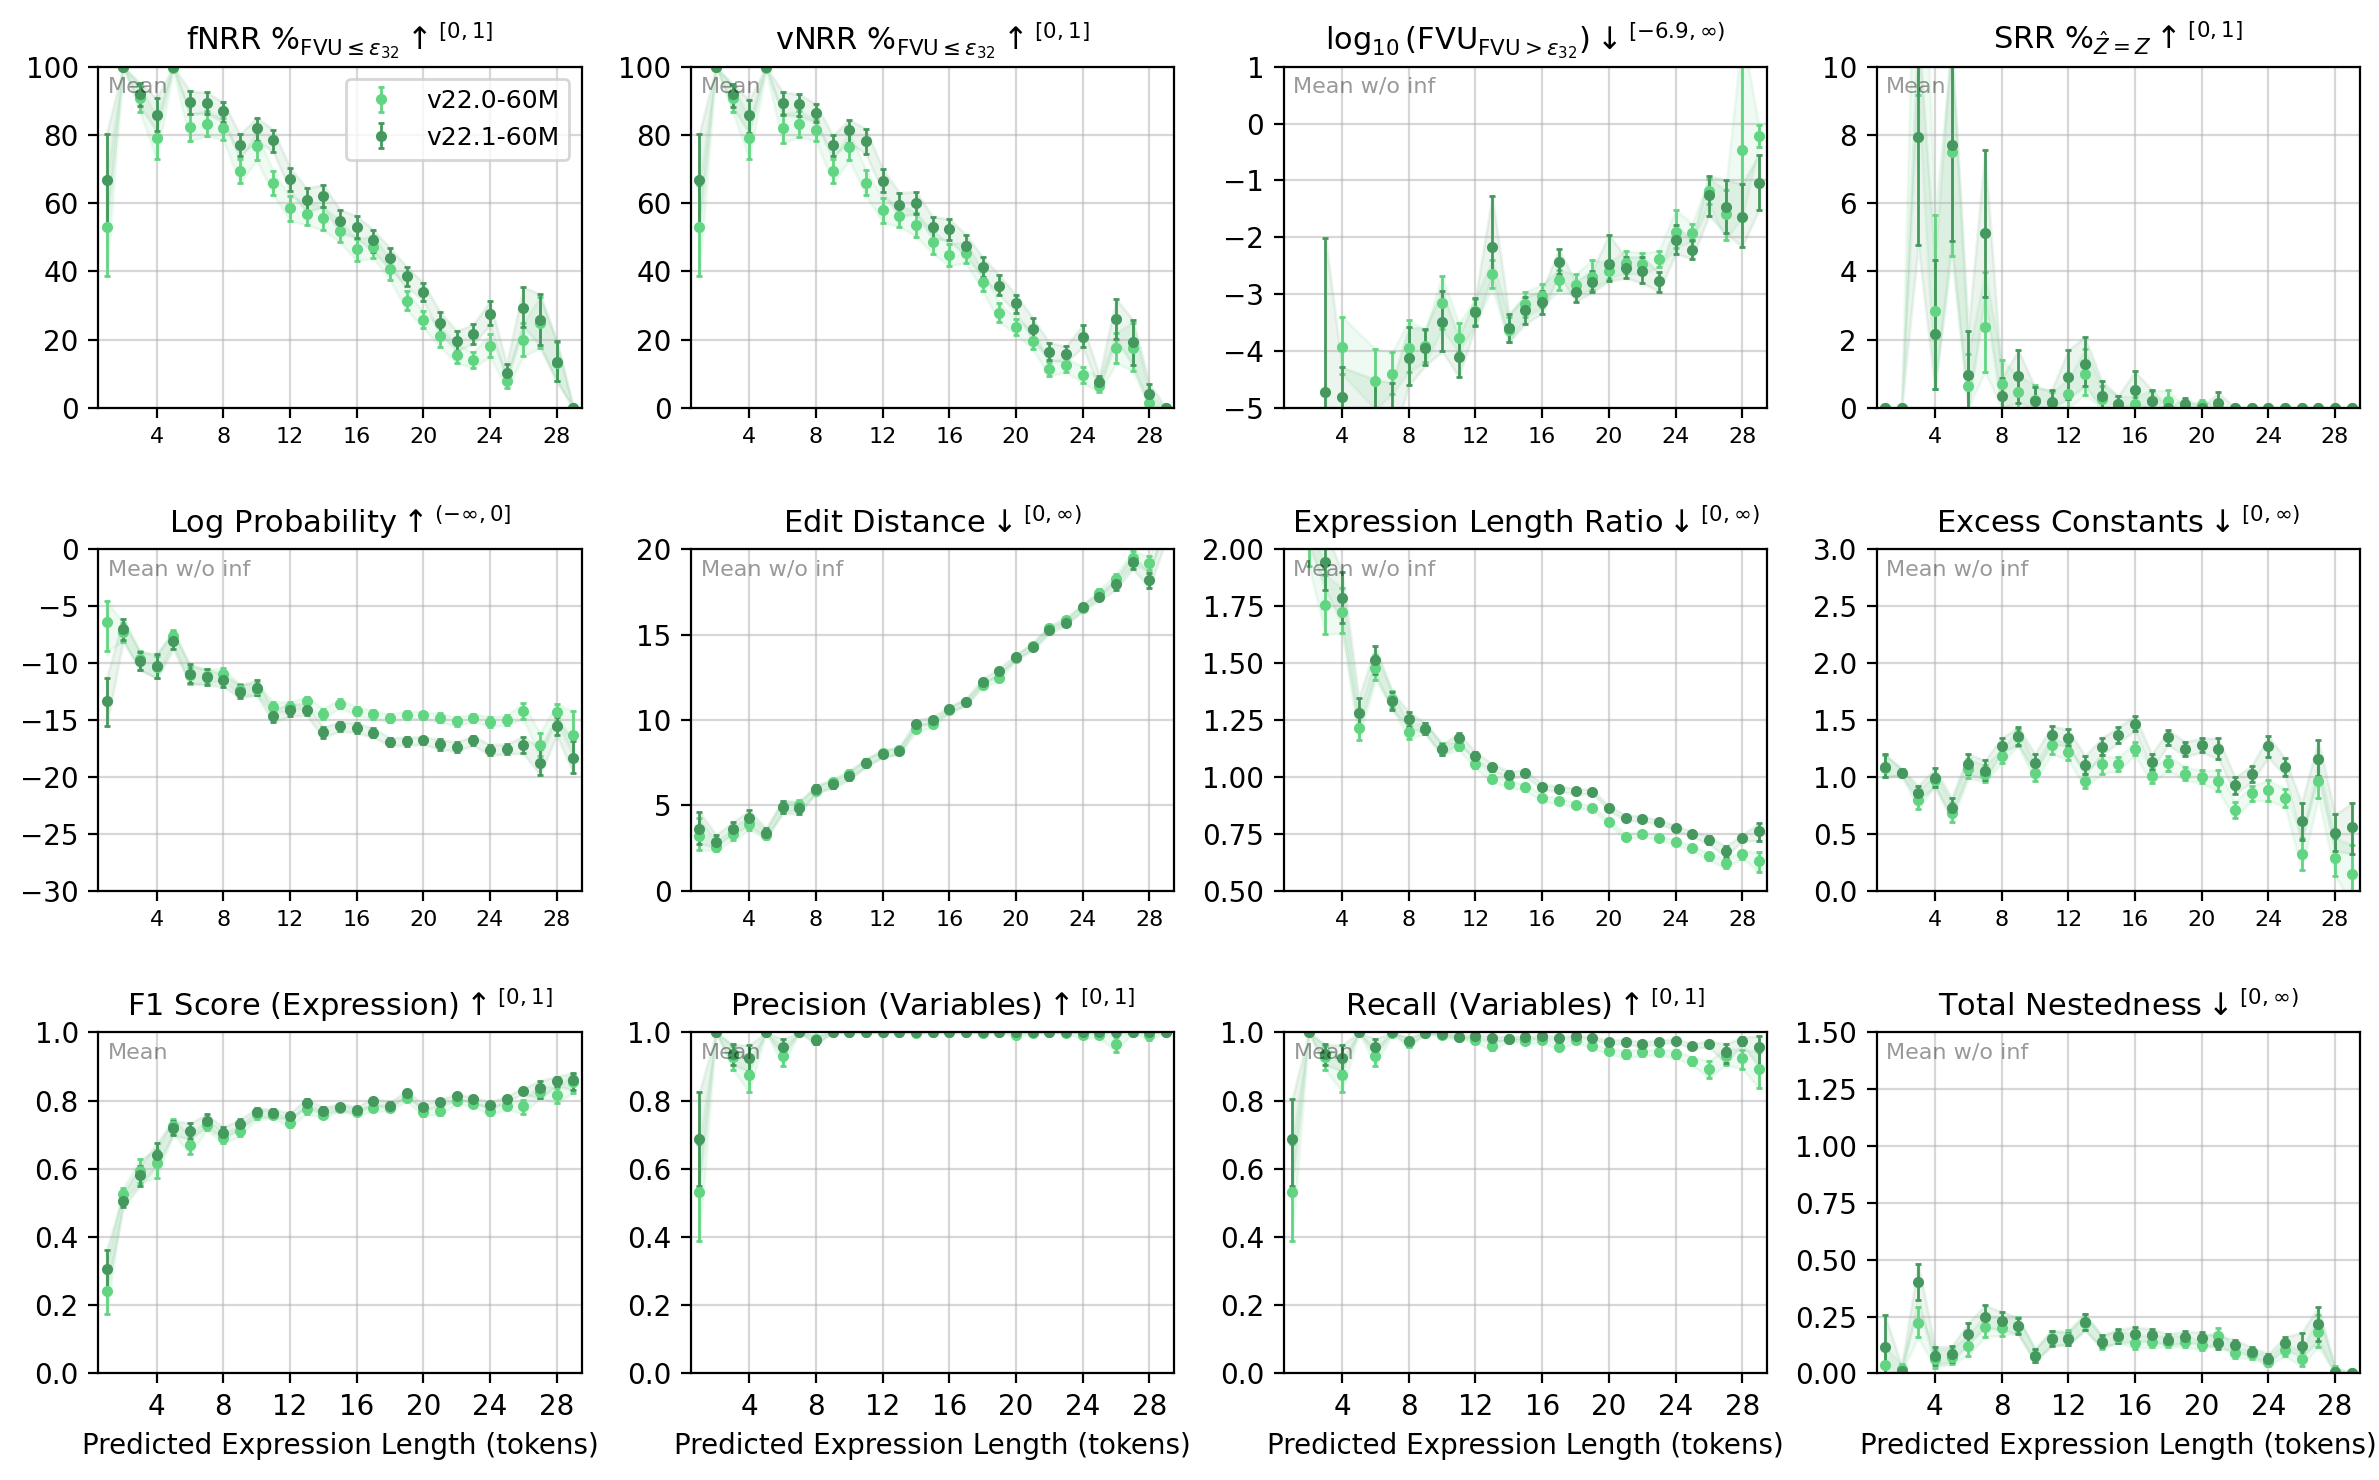

In [35]:
BIN_WIDTH = 1  # number of tokens per bin along the x-axis

metrics = [
    (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{FVU}} \\leq \\epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100),
    ),
    (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \\leq \\epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100),
    ),
    (
        'only_approx_log10_fvu_val',
        f'$\\log_{{10}}(\\mathrm{{FVU}}_{{\\mathrm{{FVU}} > \\epsilon_{{32}}}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        naninfmean,
        1,
        (-5, 1),
    ),
    (
        'symbolic_recovery',
        f'SRR $\\%_{{\\hat{{Z}} = Z}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 10),
    ),
    (
        'predicted_log_prob',
        f'$\\mathrm{{Log\\ Probability}} {arrow_notation(objective=1, lower=-np.inf, upper=0)}$',
        naninfmean,
        1,
        (-30, 0),
    ),
    (
        'edit_distance',
        f'$\\mathrm{{Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 20),
    ),
    (
        'skeleton_length_ratio',
        f'$\\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 2),
    ),
    (
        'n_constants_delta',
        f'$\\mathrm{{Excess\\ Constants}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 3),
    ),
    (
        'f1_score',
        f'$\\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.0, 1),
    ),
    (
        'precision_unique_variables',
        f'$\\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1),
    ),
    (
        'recall_unique_variables',
        f'$\\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1),
    ),
    (
        'predicted_total_nestedness',
        f'$\\mathrm{{Total\\ Nestedness}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 1.5),
    ),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v22.0-60M', '#62D582'),
    ('v22.1-60M', '#46995E'),
    ('v22.2-60M', '#429159'),
    ('v22.3-60M', '#336F44'),
    ('v22.4-60M', '#011640'),
    ('PySR', '#c53549'),
]

models = [m for m in models if m[0] in results.keys()]

test_set = 'pool_15_10'
# test_set = 'feynman'

if not models:
    raise ValueError('No matching models found in `results`.')

max_length = 0
for model_name, _ in models:
    model_results = results[model_name]['results'].get(test_set, {})
    for run_result in model_results.values():
        lengths = np.asarray(run_result['skeleton_length'], dtype=float)
        lengths = lengths[np.isfinite(lengths)]
        if lengths.size == 0:
            continue
        max_length = max(max_length, int(np.nanmax(lengths)))

if max_length == 0:
    raise ValueError(f'No finite predicted skeleton lengths available for test set {test_set!r}.')

bin_ranges = [(start, min(start + BIN_WIDTH - 1, max_length)) for start in range(1, max_length + 1, BIN_WIDTH)]
bin_centers = np.array([(lo + hi) / 2 for lo, hi in bin_ranges], dtype=float)

COLS = min(4, len(metrics))
ROWS = int(np.ceil(len(metrics) / COLS))
fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)
axes = np.atleast_2d(axes)

y_statistic_name = {
    np.nanmean: 'Mean',
    np.nanmedian: 'Median',
    naninfmean: 'Mean w/o inf',
}

for ax_id, (ax, (y_metric, y_label, y_statistic, y_factor, ylim)) in enumerate(zip(axes.flatten(), metrics)):
    ax: plt.Axes
    for model_name, color in models:
        model_results = results[model_name]['results'].get(test_set, {})
        if not model_results:
            continue

        lengths_list, values_list = [], []
        for run_result in model_results.values():
            lengths = np.asarray(run_result['skeleton_length'], dtype=float)
            values = np.asarray(run_result[y_metric], dtype=float)

            valid_mask = np.isfinite(lengths)
            lengths = lengths[valid_mask]
            values = values[valid_mask]

            if y_metric == 'only_approx_log10_fvu_val':
                finite_mask = values != -np.inf
                lengths = lengths[finite_mask]
                values = values[finite_mask]

            finite_values_mask = np.isfinite(values)
            lengths = lengths[finite_values_mask]
            values = values[finite_values_mask]

            if lengths.size == 0:
                continue

            lengths_list.append(lengths)
            values_list.append(values)

        if not lengths_list:
            continue

        lengths = np.concatenate(lengths_list)
        values = np.concatenate(values_list)

        binned_x, binned_med, binned_low, binned_high, binned_counts = [], [], [], [], []
        for (lo, hi), center in zip(bin_ranges, bin_centers):
            bin_mask = (lengths >= lo) & (lengths <= hi)
            if not np.any(bin_mask):
                continue

            bin_values = values[bin_mask]
            bin_values = bin_values[np.isfinite(bin_values)]
            if bin_values.size == 0:
                continue

            y_ci = bootstrapped_metric_ci(bin_values, y_statistic, n=1e3, interval=0.95)
            binned_x.append(center)
            binned_med.append(y_ci[0] * y_factor)
            binned_low.append(y_ci[1] * y_factor)
            binned_high.append(y_ci[2] * y_factor)
            binned_counts.append(bin_values.size)

        if not binned_x:
            continue

        binned_x = np.array(binned_x)
        order = np.argsort(binned_x)
        binned_x = binned_x[order]
        binned_med = np.array(binned_med)[order]
        binned_low = np.array(binned_low)[order]
        binned_high = np.array(binned_high)[order]
        binned_counts = np.array(binned_counts)[order]

        mask_minimum_counts = binned_counts >= 5

        ax.errorbar(
            binned_x[mask_minimum_counts],
            binned_med[mask_minimum_counts],
            yerr=[binned_med[mask_minimum_counts] - binned_low[mask_minimum_counts], binned_high[mask_minimum_counts] - binned_med[mask_minimum_counts]],
            fmt='.',
            label=model_name,
            color=color,
            capsize=1,
            elinewidth=1,
        )
        ax.fill_between(binned_x[mask_minimum_counts], binned_low[mask_minimum_counts], binned_high[mask_minimum_counts], color=color, alpha=0.1)

        # for x_val, count, low in zip(binned_x, binned_counts, binned_low):
        #     ax.annotate(
        #         f'{int(count)}',
        #         xy=(x_val, low),
        #         fontsize=5,
        #         color=color,
        #         textcoords='offset points',
        #         xytext=(0, -3),
        #         ha='center',
        #         va='top',
        #     )

    if ylim[0] is not None and ylim[1] is not None:
        ax.set_ylim(ylim)

    ax.set_title(y_label, fontsize=11)
    ax.grid(alpha=0.5)

    x_ticks_fontsize = 10 if ax_id // COLS == ROWS - 1 else 8
    xticks = np.arange(0, max_length + 1, 4)
    xticklabels = [str(int(x)) for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=x_ticks_fontsize)

    ax.set_xlim(bin_centers[0] - BIN_WIDTH / 2, bin_centers[-1] + BIN_WIDTH / 2)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel('Predicted Expression Length (tokens)')

    ax.annotate(
        y_statistic_name.get(y_statistic, y_statistic.__name__),
        xy=(0.02, 0.97),
        xycoords='axes fraction',
        fontsize=8,
        color='k',
        ha='left',
        va='top',
        alpha=0.4,
    )

for ax in axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=9)
        break

for ax in axes.flatten()[len(metrics):]:
    ax.axis('off')

fig.tight_layout(w_pad=1, h_pad=2)

In [36]:
def getCDF(data):
    data = np.array(data)
    data = data[np.isfinite(data)]
    if data.size == 0:
        return np.array([]), np.array([])
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

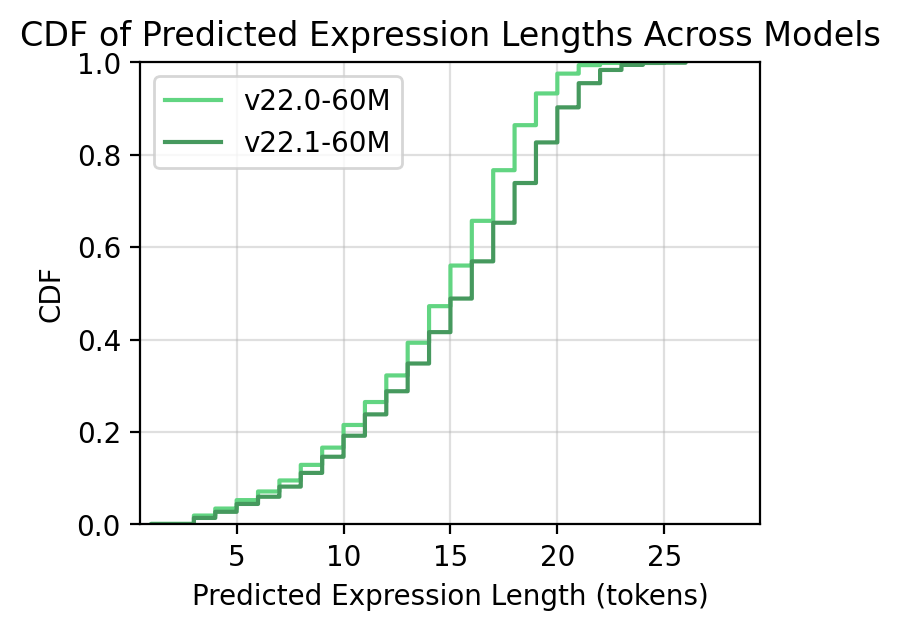

In [37]:
# Show the CDF of predicted expression lengths across all models
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
for model_name, color in models:
    model_results = results[model_name]['results'].get(test_set, {})
    if not model_results:
        continue

    lengths_list = []
    for run_result in model_results.values():
        lengths = np.asarray(run_result['predicted_skeleton_prefix_length'], dtype=float)

        valid_mask = np.isfinite(lengths)
        lengths = lengths[valid_mask]

        if lengths.size == 0:
            continue

        lengths_list.append(lengths)

    if not lengths_list:
        continue

    lengths = np.concatenate(lengths_list)
    x_cdf, y_cdf = getCDF(lengths)
    if x_cdf.size == 0:
        continue

    ax.step(x_cdf, y_cdf, where='post', label=model_name, color=color, linewidth=1.5)

ax.legend()
ax.set_xlabel('Predicted Expression Length (tokens)')
ax.set_ylabel('CDF')
ax.set_xlim(0.5, max_length + 0.5)
ax.set_ylim(0, 1)
ax.set_title('CDF of Predicted Expression Lengths Across Models')
ax.grid(alpha=0.4)
plt.show()

In [38]:
from collections import Counter

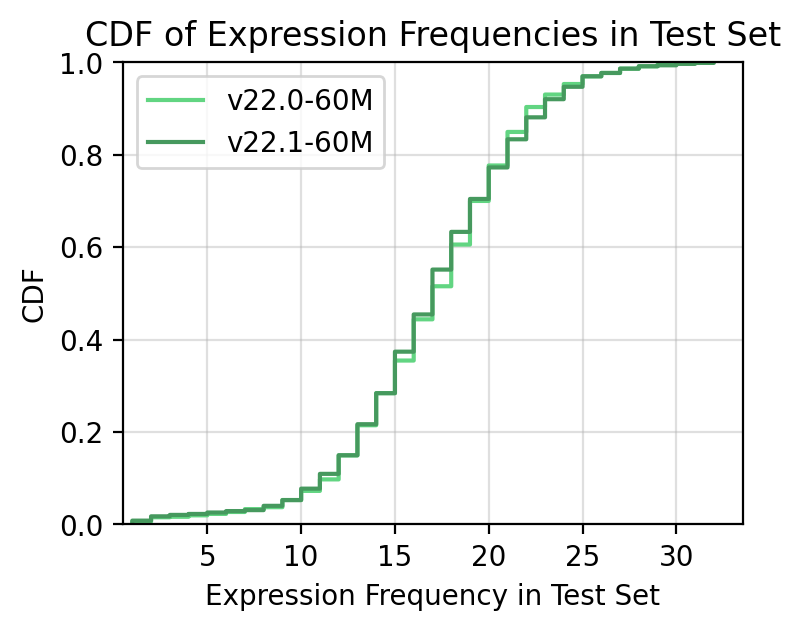

In [39]:
# CDF of the frequencies
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)

for model_name, color in models:
    model_results = results[model_name]['results'].get(test_set, {})
    if not model_results:
        continue

    skeletons_list = []
    for run_result in model_results.values():
        skeletons = run_result['skeleton']

        valid_mask = [skeleton is not None for skeleton in skeletons]
        skeletons = [skeleton for skeleton, valid in zip(skeletons, valid_mask) if valid]

        if len(skeletons) == 0:
            continue

        skeletons_list.extend(skeletons)

    if not skeletons_list:
        continue

    skeleton_counter = Counter([tuple(skeleton) for skeleton in skeletons_list])
    frequencies = np.array(list(skeleton_counter.values()))
    x_cdf, y_cdf = getCDF(frequencies)
    ax.step(x_cdf, y_cdf, where='post', label=model_name, color=color, linewidth=1.5)

# # Uniform for reference (dataset has 1000 expressions of which len(skeletons_list) have been drawn at random)
# ax.axvline(x=len(skeletons_list) / 1000, color='k', linestyle='--', alpha=0.5, label='Uniform Frequency')

ax.legend()
ax.set_xlabel('Expression Frequency in Test Set')
ax.set_ylabel('CDF')
ax.set_xlim(0.5, None)
ax.set_ylim(0, 1)
ax.set_title('CDF of Expression Frequencies in Test Set')
ax.grid(alpha=0.4)